## Model description

This builds on `generation_interval_model.ipynb` by considering 2 time periods with different reproduction numbers, with an unknown change point. The assumptions are as follows:

1. There is an initial number, `N_0`, of new infections on the 0th day.
2. Each infection leads to some number of expected secondary infections. The number of expected secondary infections after a primary infection is given by the generation interval distribution multiplied by `R`, the reproductive number, for the date of the secondary infection.
3. `R` is equal to `R_0` at the beginning, before interventions are in place, but multiplied by a ratio ` 0 < R_ratio < 1`, at some time, `change_point`, during the simulation.
4. A fraction (IFR, infection fatality rate) of new infections are expected to turn into deaths.
5. Deaths occur after an incubation period then a delay time from illness onset to death. These periods have predefined distributions, and the number of expected deaths on a given date is a convolution of the new infection over time with these 2 distributions.
6. Given the number of expected deaths on each day, the number of deaths is modeled as a Poisson process, and fit to the data.

Only the assumptions 2 and 3 are modified from the generation interval model, and now the undetermined parameters are `N_0`, `R_0`, `R_ratio`, and `change_point`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

import covid_19.covid_func as cf

Data source for Chicago:

https://www.chicago.gov/city/en/sites/covid-19/home/latest-data.html

Pickle file is created in `create_data_pickles.ipynb` notebook.

In [2]:
location = 'Chicago'

In [3]:
death_df = pd.read_pickle('../data/chi_deaths.pickle')

In [4]:
death_df.iloc[-10:]

,deaths
2020-04-22,41
2020-04-23,34
2020-04-24,44
2020-04-25,30
2020-04-26,37
2020-04-27,25
2020-04-28,32
2020-04-29,27
2020-04-30,8
2020-05-01,3


In [5]:
# Drop the last 7 days, to reduce the effects of incomplete data
death_df = death_df.iloc[:-7]

In [6]:
num_days = len(death_df)

In [7]:
death_list = list(death_df['deaths'])

#### Do a convolution

Incubation period from https://www.medrxiv.org/content/10.1101/2020.02.02.20020016v1:

Lognormal distribution with mean 5.5 days, SD 2.1 days.

In [8]:
# Use lognorm_pdf function defined in covid_func.py
mean_i = 5.5
sd_i = 2.1

incubation_pdf = cf.lognorm_pdf(mean_i, sd_i)

In [9]:
incubation_array = np.array([incubation_pdf(x) for x in range(num_days)])

Onset-to-death delay from https://www.sciencedirect.com/science/article/pii/S1473309920302437

Gamma function with mean 17.8 days, coefficient of variation 0.45.

In [10]:
# Use gamma_pdf function defined in covid_func.py
mean_d = 17.8
cov_d = 0.45
sd_d = mean_d * cov_d

delay_pdf = cf.gamma_pdf(mean_d, sd_d)

In [11]:
delay_array = np.array([delay_pdf(x) for x in range(num_days)])

Given an array of infections, create a transfer matrix that turns it in to an array of cases with symptoms. The function to do this is defined in `covid_func.py`.

This is not exactly correct, as it ignores asymptotic cases, but I will multiply the whole array by the infection fatality rate (IFR) so the final answer will be modeled correctly.

In [12]:
incubation_mat = cf.create_delay_matrix(incubation_array, num_days)

It looks like this.

In [13]:
incubation_mat[:5,:5]

array([[0.00000000e+00, 5.75004955e-05, 2.05303128e-02, 1.24416757e-01,
        2.14725998e-01],
       [0.00000000e+00, 0.00000000e+00, 5.75004955e-05, 2.05303128e-02,
        1.24416757e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.75004955e-05,
        2.05303128e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.75004955e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

Similarly

In [14]:
delay_mat = cf.create_delay_matrix(delay_array, num_days)

Multiply these 2 matrices to get the transfer matrix to go from the array of infections to the array of deaths (up to the factor of IFR).

In [15]:
transfer_mat = np.matmul(incubation_mat, delay_mat)

#### Generation interval

Following https://science.sciencemag.org/content/early/2020/04/09/science.abb6936, take the generation interval to be drawn from a Weibull distribution, with mean 5.0 days, SD of 1.9 days. (From Table 1, the actual parameters are shape of 2.826 and scale of 5.665, which reproduce the values for the mean and variance above.)

A shorter interval leads to a lower estimated R, and a larger interval leads to a higher estimated R, given the same growth in cases.

In [16]:
shape_g = 2.826
scale_g = 5.665

generation_pdf = cf.weibull_pdf(shape=shape_g, scale=scale_g)

In [17]:
generation_array = np.array([generation_pdf(x)
                             for x in range(num_days)])

At first, you have an array of infections, `[N_0, 0, 0, ...]`. You then multiply by R0 * generation_array to get the new infections generated from that first patient.

Add these patients to the infections array, then you multiply the 2nd element by a shifted version of generation_array, to get the new infections from those people.

This requires a successive multiplication by matrices. `create_infection_tensor` is a 3 dimensional array whose n-th element is the n-th matrix required in this process.

In [18]:
infection_tensor = cf.create_infection_tensor(generation_array, num_days)

#### Define the model

In [19]:
with pm.Model() as model:
    # There is a change point around March 20.
    # The range is narrowed to improve run time,
    # and is informed by recent estimates.
    change_point = pm.DiscreteUniform('change_point',
                                      lower=11 + 28,
                                      upper=24 + 28)
    
    # There is some initial number of cases
    # The prior is an exponential distribution with mean 1. 
    N_0 = pm.Exponential('initial', lam=1.)
    
    # There is a constant reproduction number.
    # The prior is distributed normally around 3.
    R_0 = pm.Normal('R_0', mu=3., sd=2.)

    # After the change point, R is multiplied by
    # a factor between 0 and 1
    R_ratio = pm.Uniform('R_ratio', lower=0., upper=1.)
    
    # Use switch to define R for all dates
    idx = np.arange(num_days)
    R = pm.math.switch(idx < change_point, R_0, R_0 * R_ratio)
    
    # The infection array is generated iteratively,
    # using the series of matrices generated above,
    # and R as a multiplicative factor at each stage.
    N_array = N_0 * np.array([1.] + [0.] * (num_days - 1))
    for tensor in infection_tensor[:-1]:
        N_array += R * pm.math.matrix_dot(N_array,
                                          tensor)
    # IFR is calculated using 
    # https://www.sciencedirect.com/science/article/pii/S1473309920302437
    # and the population by age in the US        
    IFR = 0.0095
    
    # Model proceeds as new infections -> expected new patients
    #                                  -> expected new deaths,
    # using the transfer matrices and the IFR
    exp_deaths = IFR * pm.math.matrix_dot(N_array, transfer_mat)

In [20]:
with model:
    # Given expected numbers of deaths,
    # fit to the data assuming this is a Poisson process for each day.
    D = pm.Poisson('deaths', mu=exp_deaths, observed=death_list)

In [21]:
with model:
    # Monte Carlo sampling to find the posterior distribution numerically
    step = pm.NUTS()
    trace = pm.sample(10000, tune=10000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [R_ratio, R_0, initial]
>Metropolis: [change_point]
Sampling 2 chains, 0 divergences: 100%|██████████| 40000/40000 [36:34<00:00, 18.22draws/s]  
The acceptance probability does not match the target. It is 0.9002427814572648, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


I sometimes get divergences. This is not a good sign, and I welcome any ideas for avoiding them.

Also, the distribution does not converge sometimes (the issue is normally the change point not being sampled well). Usually the fix is to increase the `tune` parameter.

/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plo

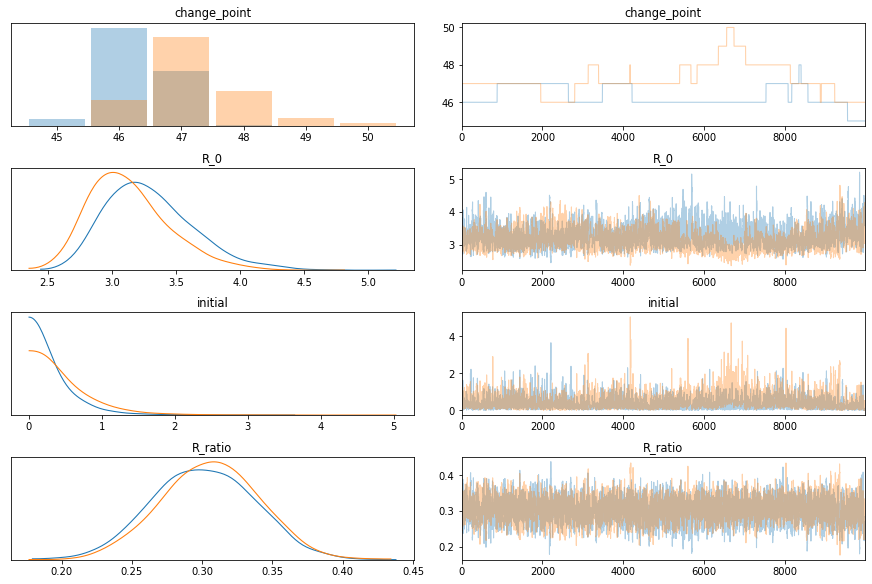

In [22]:
pm.traceplot(trace)
plt.show()

Create arrays for all simulation results.

In [23]:
change_point_array = np.array([trace['change_point']])
initial_array = np.array(trace['initial'])
R_0_array = np.array(trace['R_0'])
R_ratio_array = np.array(trace['R_ratio'])

Calculate the values of R after the change point.

In [24]:
R_array = R_0_array * R_ratio_array

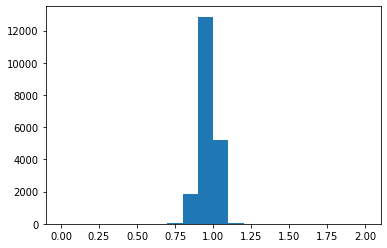

In [25]:
plt.hist(R_array, bins=np.arange(0, 2.05, .1))
plt.show()

These are the estimated current values for R, given the model assumptions.

In [26]:
# Posterior probability for R to be less than 1
np.mean(R_array < 1.)

0.7385

In [27]:
# Median estimate for R
np.median(R_array)

0.9694581014009106

Calculate the predicted number of infections for all dates, for each simulation. 

Continue the simulation for 30 more days. Obviously, the extrapolated parts are only reliable to the extent that people's behaviors stay roughly the same in the next 30 days.

In [28]:
# This is the set of predictions for all simulations for each day
N_matrix = cf.batch_predict_N_change_point(initial_array=initial_array,
                                           R_0_array=R_0_array,
                                           R_ratio_array=R_ratio_array,
                                           change_point_array=change_point_array,
                                           num_days=num_days + 30,
                                           generation_pdf=generation_pdf)

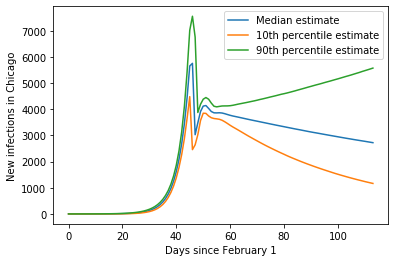

In [29]:
x = np.arange(num_days + 30)
y_median = cf.percentile_prediction(N_matrix, 50)
y_10 = cf.percentile_prediction(N_matrix, 10)
y_90 = cf.percentile_prediction(N_matrix, 90)
plt.plot(x, y_median, label='Median estimate')
plt.plot(x, y_10, label='10th percentile estimate')
plt.plot(x, y_90, label='90th percentile estimate')
plt.xlabel('Days since February 1')
plt.ylabel(f'New infections in {location}')
plt.legend()
plt.show()

Plot on log scale.

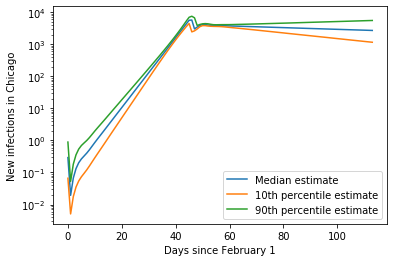

In [30]:
plt.plot(x, y_median, label='Median estimate')
plt.plot(x, y_10, label='10th percentile estimate')
plt.plot(x, y_90, label='90th percentile estimate')
plt.xlabel('Days since February 1')
plt.ylabel(f'New infections in {location}')
plt.legend()
plt.yscale('log')
plt.show()

Plot the cumulative number of infections in these simulations.

In [31]:
total_matrix = np.cumsum(N_matrix, axis=1)

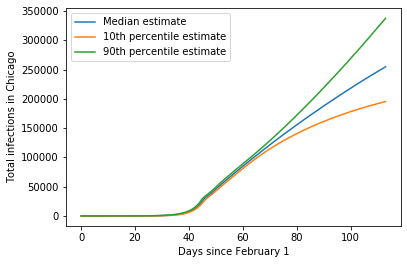

In [32]:
total_median = cf.percentile_prediction(total_matrix, 50)
total_10 = cf.percentile_prediction(total_matrix, 10)
total_90 = cf.percentile_prediction(total_matrix, 90)
plt.plot(x, total_median, label='Median estimate')
plt.plot(x, total_10, label='10th percentile estimate')
plt.plot(x, total_90, label='90th percentile estimate')
plt.xlabel('Days since February 1')
plt.ylabel(f'Total infections in {location}')
plt.legend()
plt.show()

You can plot the percentage of population (Chicago's population is ~2.7M)

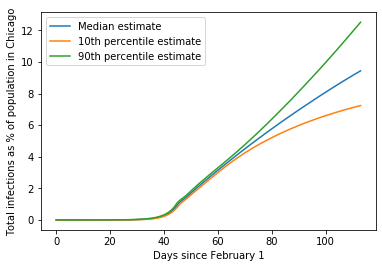

In [33]:
total_median = cf.percentile_prediction(total_matrix, 50)
total_10 = cf.percentile_prediction(total_matrix, 10)
total_90 = cf.percentile_prediction(total_matrix, 90)
plt.plot(x, total_median / 2.7e6 * 100, label='Median estimate')
plt.plot(x, total_10 / 2.7e6 * 100, label='10th percentile estimate')
plt.plot(x, total_90 / 2.7e6 * 100, label='90th percentile estimate')
plt.xlabel('Days since February 1')
plt.ylabel(f'Total infections as % of population in {location}')
plt.legend()
plt.show()

Calculate the expected number of deaths, and compare the predictions with actual numbers.

In [34]:
deaths_matrix = cf.batch_predict_deaths_from_infections(N_matrix,
                                                        incubation_pdf,
                                                        delay_pdf)

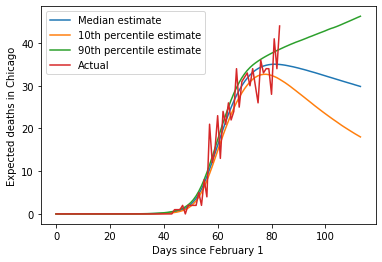

In [35]:
deaths_median = cf.percentile_prediction(deaths_matrix, 50)
deaths_10 = cf.percentile_prediction(deaths_matrix, 10)
deaths_90 = cf.percentile_prediction(deaths_matrix, 90)
plt.plot(x, deaths_median, label='Median estimate')
plt.plot(x, deaths_10, label='10th percentile estimate')
plt.plot(x, deaths_90, label='90th percentile estimate')
plt.plot(range(num_days), death_list, label='Actual')
plt.xlabel('Days since February 1')
plt.ylabel(f'Expected deaths in {location}')
plt.legend()
plt.show()